In [1]:
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

import logistic_glmm_lib as logit_glmm
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

import matplotlib.pyplot as plt
%matplotlib inline

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json
import subprocess

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

#analysis_name = 'simulated_data_small'
analysis_name = 'criteo_subsampled'

git_dir_cmd = subprocess.run(
    ['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE)
assert git_dir_cmd.returncode == 0
git_dir = git_dir_cmd.stdout.decode("utf-8").strip()

data_dir = os.path.join(git_dir, 'code/criteo_experiment/data')

pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')
vb_results = pickle.load(pkl_file)


In [3]:
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)

K = x_mat.shape[1]
NG = np.max(y_g_vec) + 1

# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)
glmm_par.set_free(vb_results['glmm_par_free'])
model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, vb_results['num_gh_points'])
objective = obj_lib.Objective(model.glmm_par, model.get_kl)
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
moment_vec = moment_wrapper.get_moment_vector_from_free(vb_results['glmm_par_free'])

print(vb_results.keys())

dict_keys(['NG', 'N', 'K', 'y_group', 'y', 'x', 'beta_prior_mean', 'beta_prior_info', 'mu_prior_mean', 'mu_prior_info', 'tau_prior_alpha', 'tau_prior_beta'])
dict_keys(['glmm_par_free', 'glmm_par_vector', 'kl_hess_packed', 'moment_jac', 'prior_par_vec', 'num_groups', 'beta_dim', 'num_gh_points', 'y_g_vec', 'y_vec', 'x_mat', 'run_name', 'vb_time', 'hess_time', 'inverse_time', 'cg_row_time', 'num_cg_iterations', 'lrvb_cov', 'kl_inv_moment_jac', 'vb_prior_sens', 'log_prior_hess'])


In [4]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, prior_par, gtol=1e-6, maxiter=500):
    model.prior_par.set_vector(prior_par.get_vector())
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x


In [5]:

perturb_prior_par = 'mu_prior_info'
epsilon_list = np.linspace(0.0, 10.0, 20)
moment_vec_list = []

glmm_opt_pert = vb_results['glmm_par_free']
vb_refit_time = time.time()
for epsilon in epsilon_list:
    print('Epsilon: ', epsilon)
    prior_par_pert = copy.deepcopy(prior_par)
    prior_par_pert[perturb_prior_par].set(prior_par[perturb_prior_par].get() + epsilon)

    glmm_opt_pert = tr_optimize(trust_init=glmm_opt_pert, prior_par=prior_par_pert)
    moment_vec_list.append(moment_wrapper.get_moment_vector_from_free(glmm_opt_pert))
    
vb_refit_time = time.time() - vb_refit_time

Epsilon:  0.0
Iter  0  value:  22970.02914673958
         Current function value: 22970.029147
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Epsilon:  0.5263157894736842
Iter  0  value:  22971.090388007247
Iter  5  value:  22971.0779541975
Optimization terminated successfully.
         Current function value: 22971.068067
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 0
Epsilon:  1.0526315789473684
Iter  0  value:  22972.08514269774
Iter  5  value:  22972.073874314756
Iter  10  value:  22972.064209355904
Optimization terminated successfully.
         Current function value: 22972.064209
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 0
Epsilon:  1.5789473684210527
Iter  0  value:  22973.039854666717
Iter  5  value:  22973.02894658009
Iter  10  value:  22973.020194525

Refit time:  1164.494928598404
Refit time per iteration:  61.289206768337046


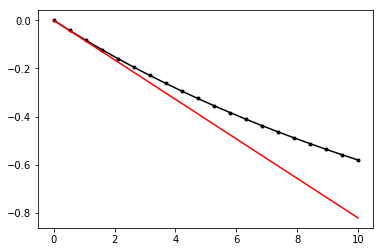

In [6]:
prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(np.arange(prior_indices.vector_size()))
mu_info_col = prior_indices[perturb_prior_par].get()[0]

pred_sens_vec = vb_results['vb_prior_sens'][:, mu_info_col]

moment_wrapper.moment_par.set_vector(pred_sens_vec)
mu_pred_sens = moment_wrapper.moment_par['e_mu'].get()[0]

moment_wrapper.moment_par.set_vector(moment_vec)

def GetEMu(moment_vec):
    moment_wrapper.moment_par.set_vector(moment_vec)
    return np.squeeze(moment_wrapper.moment_par['e_mu'].get())
    
e_mu_list = [ GetEMu(moment_vec) for moment_vec in moment_vec_list ]
e_mu_base = e_mu_list[0]

plt.plot(epsilon_list, e_mu_list - e_mu_base, 'k.')
plt.plot(epsilon_list, e_mu_list - e_mu_base, 'k')
plt.plot(epsilon_list, epsilon_list * mu_pred_sens, 'r')

print('Refit time: ', vb_refit_time)

# Note that this includes a "refit" at the zero point -- let's just remove it
# and bias the result slightly against us.
print('Refit time per iteration: ', vb_refit_time / (len(epsilon_list) - 1))

In [7]:
pickle_output_filename = os.path.join(data_dir, '%s_python_vb_perturbation_results.pkl' % analysis_name)
pickle_output = open(pickle_output_filename, 'wb')

# Unlike with JSON, numpy arrays can be pickled.
pickle_result_dict = {  'pickle_output_filename': pickle_output_filename,
                        'vb_refit_time': vb_refit_time,
                        'epsilon_list': epsilon_list,
                        'moment_vec_list': moment_vec_list,
                        'perturb_prior_par': perturb_prior_par
                     }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_output_filename)


print('\n\nDONE.')


/home/rgiordan/Documents/git_repos/CovariancesRobustnessVBPaper/code/criteo_experiment/data/criteo_subsampled_python_vb_perturbation_results.pkl


DONE.
